In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import cv2

2024-11-11 18:13:41.674246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731348821.740728    9273 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731348821.759484    9273 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 18:13:41.912354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define image dimensions and paths
IMG_HEIGHT, IMG_WIDTH = 229, 229
data_dir = 'Chess'

images, labels = [], []

# Map each folder name to a numerical label
class_names = os.listdir(data_dir)
label_map = {name: idx for idx, name in enumerate(class_names)}

# Load images and labels
for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        
        # Load image and check if it's loaded correctly
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Unable to load image {img_path}")
            continue  

        img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
        images.append(img)
        labels.append(label_map[class_name])

images = np.array(images)
labels = np.array(labels)


In [7]:
# Normalize pixel values
images = images / 255.0

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Number of images without augmentation: {len(X_train)}")

# Define the data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow(X_train, y_train, batch_size=32)
val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size=32)
test_gen = ImageDataGenerator().flow(X_test, y_test, batch_size=32)

print(f"Number of images with augmentation (effective dataset size): {len(train_gen) * 32}")


Number of images without augmentation: 444
Number of images with augmentation (effective dataset size): 448


In [8]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1731349065.116197    9273 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20933 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


In [9]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_chessman_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1731349135.180644   11944 service.cc:148] XLA service 0x7f0480007050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731349135.180977   11944 service.cc:156]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-11-11 18:18:55.269594: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731349135.565017   11944 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/14 ━━━━━━━━━━━━━━━━━━━━ 1:47 8s/step - accuracy: 0.1250 - loss: 1.7918

I0000 00:00:1731349141.311841   11944 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 784ms/step - accuracy: 0.1733 - loss: 2.5670 - val_accuracy: 0.1455 - val_loss: 3.2793 - learning_rate: 0.0010
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.1652 - loss: 3.2861 - val_accuracy: 0.1455 - val_loss: 6.2169 - learning_rate: 0.0010
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.1769 - loss: 3.2825 - val_accuracy: 0.1455 - val_loss: 8.0622 - learning_rate: 0.0010
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.1652 - loss: 3.2479 - val_accuracy: 0.1455 - val_loss: 9.0632 - learning_rate: 0.0010
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.1485 - loss: 3.3507 - val_accuracy: 0.1455 - val_loss: 10.3728 - learning_rate: 5.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.1476 - loss: 3.2122 - val_accuracy: 0.1455 - val_loss: 11.9691 - learning_rate: 5.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.1883 - loss: 2.8711 - 

In [10]:
print("Class-to-label mapping:")
for class_name, label in label_map.items():
    print(f"{class_name}: {label}")

Class-to-label mapping:
Bishop: 0
King: 1
Knight: 2
Pawn: 3
Queen: 4
Rook: 5


In [12]:
from keras_tuner import RandomSearch

def build_tuned_model(hp):
    model = Sequential([
        Conv2D(hp.Int('conv1_units', 32, 128, step=32), (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D((2, 2)),
        Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.4])),

        Conv2D(hp.Int('conv2_units', 64, 256, step=64), (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(hp.Choice('dropout_2', [0.3, 0.4, 0.5])),

        Flatten(),
        Dense(hp.Int('dense_units', 128, 512, step=128), activation='relu'),
        Dropout(hp.Choice('dropout_3', [0.4, 0.5, 0.6])),
        Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_tuned_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='chessman_tuning_2',
    project_name='chessman_hyperparameter_tuning'
)

tuner.search(train_gen, epochs=10, validation_data=val_gen)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 43s]
val_accuracy: 0.20000000298023224

Best val_accuracy So Far: 0.2181818187236786
Total elapsed time: 00h 07m 45s


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the base model layers to prevent updates during initial training
base_model.trainable = False

# Add custom layers on top of the pretrained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_resnet_model.keras', save_best_only=True, monitor='val_loss')

# Adaptive learning rate callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 978ms/step - accuracy: 0.1528 - loss: 1.7956 - val_accuracy: 0.2000 - val_loss: 1.9575 - learning_rate: 0.0010
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - accuracy: 0.1668 - loss: 1.8077 - val_accuracy: 0.2000 - val_loss: 2.0209 - learning_rate: 0.0010
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.1410 - loss: 1.8453 - val_accuracy: 0.2000 - val_loss: 2.0341 - learning_rate: 0.0010
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.2213 - loss: 1.8174 - val_accuracy: 0.2000 - val_loss: 2.0366 - learning_rate: 0.0010
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.1761 - loss: 1.8376 - val_accuracy: 0.2000 - val_loss: 2.0426 - learning_rate: 5.0000e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.1943 - loss: 1.8212 - val_accuracy: 0.2000 - val_loss: 2.0735 - learning_rate: 5.0000e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.1980 -

In [17]:
from tensorflow.keras.optimizers import Adam
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine_tune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.2108 - loss: 1.7989 - val_accuracy: 0.2000 - val_loss: 1.9567 - learning_rate: 1.0000e-04
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - accuracy: 0.1446 - loss: 1.8175 - val_accuracy: 0.2000 - val_loss: 1.8782 - learning_rate: 1.0000e-04
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 324ms/step - accuracy: 0.1660 - loss: 1.8050 - val_accuracy: 0.2000 - val_loss: 1.8422 - learning_rate: 1.0000e-04
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.2178 - loss: 1.7877 - val_accuracy: 0.2000 - val_loss: 2.0190 - learning_rate: 1.0000e-04
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.1785 - loss: 1.8056 - val_accuracy: 0.2182 - val_loss: 2.6910 - learning_rate: 1.0000e-04
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.1675 - loss: 1.8134 - val_accuracy: 0.2182 - val_loss: 3.0693 - learning_rate: 1.0000e-04
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.

In [18]:
# Load the best model
model = tf.keras.models.load_model('best_resnet_model.keras')

# Predict classes for test set
y_pred = np.argmax(model.predict(test_gen), axis=1)

# Calculate accuracy, precision, recall, and F1-score
test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step
Test Accuracy: 21.43%
Precision: 4.59%
Recall: 21.43%
F1 Score: 7.56%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


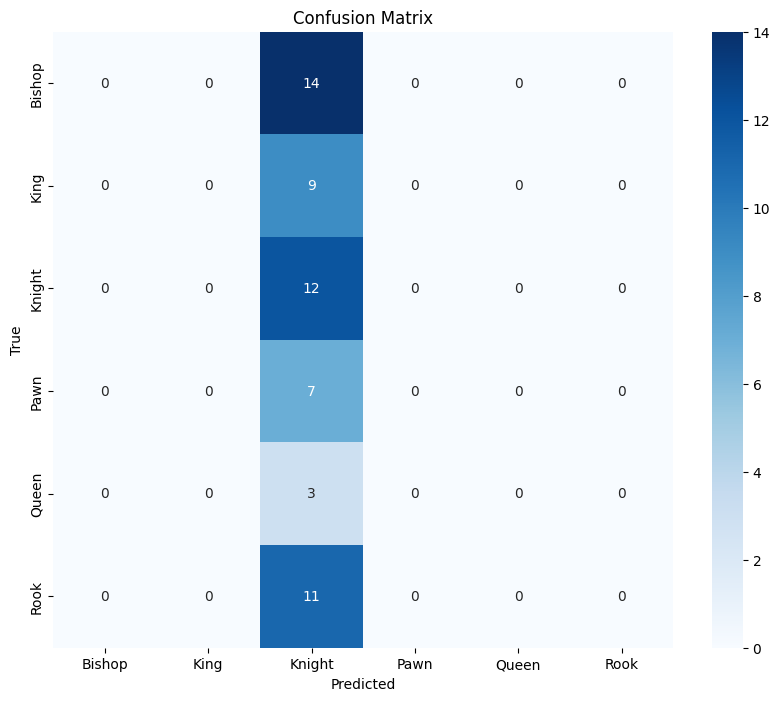

In [19]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
def load_and_preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

# Test on a new image
custom_image_path = 'quees.jpg'
custom_image = load_and_preprocess_image(custom_image_path)
prediction = np.argmax(model.predict(custom_image), axis=1)[0]

print(f"The predicted class is: {class_names[prediction]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The predicted class is: Knight


In [21]:
from keras_tuner import Hyperband
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    # Load the base ResNet50 model
    base_model = tf.keras.applications.ResNet50(
        weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )
    base_model.trainable = False  # Freeze the base model layers

    # Build the custom model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Tune the number of units in the dense layer and dropout rate
    x = Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1))(x)
    output = Dense(len(class_names), activation='softmax')(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=output)

    # Tune the learning rate for the Adam optimizer
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [22]:
# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='chess_tuning_2',
    project_name='resnet50_tuning'
)

# Perform the hyperparameter search
tuner.search(train_gen, validation_data=val_gen, epochs=20,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Trial 30 Complete [00h 00m 41s]
val_accuracy: 0.1818181872367859

Best val_accuracy So Far: 0.2181818187236786
Total elapsed time: 00h 17m 33s


In [23]:
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model with pretrained ImageNet weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model's layers to retain learned features
base_model.trainable = False

# Build custom classifier on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(len(class_names), activation='softmax')(x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_inception_model.keras', save_best_only=True)
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2070 - loss: 1.7908 - val_accuracy: 0.1818 - val_loss: 1.7796
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.2046 - loss: 1.7869 - val_accuracy: 0.1818 - val_loss: 1.7949
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.1960 - loss: 1.7858 - val_accuracy: 0.1818 - val_loss: 1.9025
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.2093 - loss: 1.7845 - val_accuracy: 0.1818 - val_loss: 2.0008
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.1971 - loss: 1.7842 - val_accuracy: 0.1818 - val_loss: 2.0508
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.2562 - loss: 1.7685 - val_accuracy: 0.1818 - val_loss: 1.9907
